In [1]:
import numpy as np
import pandas as pd
import os
import pickle

from scipy.stats import f_oneway, ttest_rel
import time
import shap

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import numpy as np
from scipy.stats import kruskal, wilcoxon, mannwhitneyu
from statsmodels.stats.multitest import multipletests
import pandas as pd


# Import Helper Modules
from Preprocessing_Modules.Preprocess import create_dataset, extract_X_Y_SIM
from Preprocessing_Modules.Features import feature_names
from GP_Modules.NSGA2 import configure_NSGA2_GP, NSGA2
from Evaluation_Modules.GP_Eval import evaluate_solution
from GridSearch_Modules.Classifiers import decision_tree_gs, logistic_regression_gs, neural_network_gs, random_forest_gs, svm_gs
from Preprocessing_Modules.Preprocess import extract_test_train
from GridSearch_Modules.Classifiers import calculate_metrics
from Evaluation_Modules.Threshold_Eval import best_possible_threshold
from GridSearch_Modules.Classifiers import get_scores

c:\Users\FeyiA\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **Classifier Comparison and Significance Testing**

This notebook evaluates the performance of multiple classifiers against the GP model, using a dataset split into two parts: one for hyperparameter tuning (grid search) and the other for evaluation.
1. **Dataset Preparation**:
   - Split into two halves:
     - **Grid Search Set**: Used to tune hyperparameters for each classifier.
     - **Evaluation Set**: Used for 5-fold cross-validation to evaluate classifier performance.

2. **Hyperparameter Tuning**:
   - Perform grid search to find the best parameters for each classifier.

3. **Evaluation**:
   - Train and test each classifier using the best parameters on the evaluation set.

4. **Statistical Significance Testing**:
   - **ANOVA**: Compare mean accuracy across all classifiers to check for overall differences.
   - **Paired \( t \)-tests**: Compare GP with each classifier directly.

5. **Visualization**:
   - Boxplot of accuracy distributions/classifier performance.


In [2]:
# Step 1: Create Dataset and Split into Two Halves
num_rows = 10000
# df = create_dataset(subset_percent = 1, num_rows = num_rows, embedding = False)
df = create_dataset(subset_percent = 1, num_rows = num_rows)
midpoint = len(df) // 2

# Split into grid search and evaluation sets
df_first_half = df.iloc[:midpoint]
df_second_half = df.iloc[midpoint:]
df

File found and loaded into DataFrame:


,is_duplicate,question1,question2,question1_tokens,question2_tokens,evolve_features,similarity
0,0,What is the lowest post an IAS would get after...,How does it feel after an IAS gets promoted fr...,"[lowest, post, ia, would, get, qualifying, ia]","[feel, ia, get, promoted, dm, secretary]","[0.8571428571428571, 0.42857142857142855, 0.40...",0.395011
1,1,What is the worst start up business idea that ...,What is the worst possible business idea you h...,"[worst, start, business, idea, ever, heard]","[worst, possible, business, idea, heard, seen]","[1.0, 0.6666666666666666, 0.5773502691896258, ...",0.864275
2,0,Is Politico biased? Republican or Democrat?,Is Jake Tapper a republican or democrat?,"[politico, biased, republican, democrat]","[jake, tapper, republican, democrat]","[1.0, 0.75, 0.5, 0.4090909090909091, 0.3333333...",0.371252
3,1,What is the salary after becoming income tax o...,What is the salary of fresher income tax officer?,"[salary, becoming, income, tax, officer]","[salary, fresher, income, tax, officer]","[1.0, 0.8, 0.82502864732539, 0.55, 0.666666666...",0.889240
4,0,What is MRI scanning?,What happens when you get an MRI scan?,"[mri, scanning]","[happens, get, mri, scan]","[0.5, 0.0, 0.7071067811865475, 0.2727272727272...",0.787193
...,...,...,...,...,...,...,...
9995,1,What are Hillary Clinton's plans for India?,What is Hillary Clinton's foreign policy outlo...,"[hillary, clinton, plan, india]","[hillary, clinton, foreign, policy, outlook, r...","[0.5714285714285714, 0.42857142857142855, 0.81...",0.832848
9996,1,What is it like to be retained (held back) a g...,Have you ever been dropped back a grade in sch...,"[like, retained, held, back, grade, school]","[ever, dropped, back, grade, school]","[0.8333333333333334, 0.5, 0.4629100498862757, ...",0.688439
9997,1,What is the proper diet to gain weight?,What is the best diet to gain weight?,"[proper, diet, gain, weight]","[best, diet, gain, weight]","[1.0, 0.75, 1.0000000000000002, 0.6, 0.6, 0.86...",0.935621
9998,0,What is Pradhan Mantri Fasal Bima Yojna (PMFBY...,How is Gold Monetisation Scheme different from...,"[pradhan, mantri, fasal, bima, yojna, pmfby, d...","[gold, monetisation, scheme, different, previo...","[0.8461538461538461, 0.6923076923076923, 0.836...",0.441308


In [3]:
# Step 2: Grid Search on First Half
_, _, _, [X_train_gs, X_test_gs, Y_train_gs, Y_test_gs, Similarity_train_gs, Similarity_test_gs] = extract_test_train(df_first_half)
X_train_gs_embed = np.hstack((X_train_gs, Similarity_train_gs.reshape(-1, 1)))
X_test_gs_embed = np.hstack((X_test_gs, Similarity_test_gs.reshape(-1, 1)))

Training Size: 4000
Test Size: 1000




In [4]:
# Parameter Grids for search
param_grids = {
    "DT": 
    {
    'criterion': ['gini', 'entropy', 'log_loss'],  
    'max_depth': [None, 10, 20, 30],           
    'min_samples_split': [2, 5],            
    'min_samples_leaf': [1, 2, 5],             
    'max_features': [None, 'sqrt', 'log2'], 
    'splitter': ['best', 'random'],              
    'class_weight': [None, 'balanced'],          
    },
    "LR": [
        {
            'C': np.logspace(-4, 4, 10),
            'penalty': ['l2'],           
            'solver': ['lbfgs'], 
            'max_iter': [1000],        
        },
        {
            'C': np.logspace(-4, 4, 10),  
            'penalty': ['l1'],           
            'solver': ['saga'],   
            'max_iter': [1000],      
        },
        {
            'C': np.logspace(-4, 4, 10),
            'penalty': ['l2'],           
            'solver': ['saga'],  
            'max_iter': [1000],        
        },
    ],
    "RF": {
         'n_estimators': [50, 100, 200, 500],
        'max_depth':  [None, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5],
        'max_features': ['sqrt', 'log2']
    },
    "SVM": [
        {
            'C': np.logspace(-2, 2, 3),
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto'],  
            'probability': [True]
        },
    ],
    "NN": {
        'hidden_layer_sizes': [
             (50,), (100,), (50, 20), (50, 20, 10), (100, 50, 20)
            ],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive'],
        'early_stopping': [True],
    }
}

In [5]:
def perform_grid_search(name, param_grid, X_train, X_test, Y_train, Y_test):
    if "DT" in name:
        return decision_tree_gs(param_grid, X_train, X_test, Y_train, Y_test)
    elif "LR" in name:
        return logistic_regression_gs(param_grid, X_train, X_test, Y_train, Y_test)
    elif "RF" in name:
        return random_forest_gs(param_grid, X_train, X_test, Y_train, Y_test)
    elif "SVM" in name:
        return svm_gs(param_grid, X_train, X_test, Y_train, Y_test)
    elif "NN" in name:
        return neural_network_gs(param_grid, X_train, X_test, Y_train, Y_test)
    else:
        raise ValueError(f"Unsupported model type: {name}")


def get_pickle_file_name(num_rows, directory="saved_runs", file_type="params"):
    os.makedirs(directory, exist_ok=True)
    file_suffix = "timings.pkl" if file_type == "timings" else "params.pkl"
    return os.path.join(directory, f"best_{file_type}_{num_rows}.{file_suffix}")


def load_or_run_grid_search(param_grids, X_train, X_test, X_train_embed, X_test_embed, Y_train, Y_test, num_rows, directory="saved_runs"):
    param_file = get_pickle_file_name(num_rows, directory, file_type="params")
    timing_file = get_pickle_file_name(num_rows, directory, file_type="timings")

    if os.path.exists(param_file) and os.path.exists(timing_file):
        print(f"Loading best parameters from {param_file} and timings from {timing_file}")
        with open(param_file, "rb") as pf, open(timing_file, "rb") as tf:
            best_params = pickle.load(pf)
            grid_search_timings = pickle.load(tf)
        return best_params, grid_search_timings

    else:
        print("Running grid search...")
        best_params = {}
        grid_search_timings = {}

        for name, param_grid in param_grids.items():
            # Perform grid search for regular features
            start_time = time.time()
            print(f"Fine-Tuned {name} Performance (Grid Search):")
            best_model, best_model_params, *metrics = perform_grid_search(
                name, param_grid, X_train, X_test, Y_train, Y_test
            )
            elapsed_time = time.time() - start_time
            best_params[name] = best_model_params
            grid_search_timings[name] = elapsed_time

            # Perform grid search for embeddings
            embed_name = f"{name}_Embed"
            start_time = time.time()
            print(f"Fine-Tuned {embed_name} Performance (Grid Search):")
            best_model, best_model_params, *metrics = perform_grid_search(
                embed_name, param_grid, X_train_embed, X_test_embed, Y_train, Y_test
            )
            elapsed_time = time.time() - start_time
            best_params[embed_name] = best_model_params
            grid_search_timings[embed_name] = elapsed_time

        # Save both best parameters and timings
        with open(param_file, "wb") as pf, open(timing_file, "wb") as tf:
            pickle.dump(best_params, pf)
            pickle.dump(grid_search_timings, tf)

        return best_params, grid_search_timings


In [6]:
# Run grid search and track timings
best_params, grid_search_timings = load_or_run_grid_search(
    param_grids, X_train_gs, X_test_gs, X_train_gs_embed, X_test_gs_embed, Y_train_gs, Y_test_gs, num_rows
)

Loading best parameters from saved_runs\best_params_10000.params.pkl and timings from saved_runs\best_timings_10000.timings.pkl


In [7]:
# Step 3: Evaluation on Second Half
X_eval, Y_eval, SIMILARITY_eval = extract_X_Y_SIM(df_second_half)
kf_eval = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
splits_eval = [(train_idx, test_idx) for train_idx, test_idx in kf_eval.split(X_eval, Y_eval)]


In [8]:
def get_folds_file_name(num_rows, directory="saved_runs", file_type="folds"):
    os.makedirs(directory, exist_ok=True)
    file_suffix = "fold_results.pkl" if file_type == "folds" else "other.pkl"
    return os.path.join(directory, f"{file_type}_{num_rows}.{file_suffix}")


def save_fold_results(fold_results, timing_results, num_rows, directory="saved_runs"):
    file_path = get_folds_file_name(num_rows, directory, file_type="folds")
    with open(file_path, "wb") as f:
        pickle.dump({"fold_results": fold_results, "timing_results": timing_results}, f)
    print(f"Fold results saved to {file_path}")


def load_fold_results(num_rows, directory="saved_runs"):
    file_path = get_folds_file_name(num_rows, directory, file_type="folds")
    if os.path.exists(file_path):
        with open(file_path, "rb") as f:
            print(f"Loading fold results from {file_path}")
            data = pickle.load(f)
            return data["fold_results"], data["timing_results"]
    else:
        print("No saved fold results found. Proceeding to compute.")
        return None, None


In [9]:
# Initialize timing storage
timing_storage = {
    model_name: {"grid_search_time": grid_search_timings.get(model_name, 0), "train_eval_times": []}
    for model_name in best_params.keys()
}

# Update metrics storage to include timing
metrics_storage = {}
for model_name in ["GP", "GP_Embed", "Static"]:
    metrics_storage[model_name] = []
    timing_storage[model_name] =  {"grid_search_time": 0, "train_eval_times": []}

for model_name, _ in best_params.items():
    metrics_storage[model_name] = []

def get_metrics(clf, X_test, Y_test):
    accuracy, precision, recall, f1, cm, fpr, tpr, roc_auc = calculate_metrics(clf, X_test, Y_test)
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

def process_fold(train_idx, test_idx):
    # Split data
    X_train, X_test = X_eval[train_idx], X_eval[test_idx]
    Y_train, Y_test = Y_eval[train_idx], Y_eval[test_idx]
    SIMILARITY_train, SIMILARITY_test = SIMILARITY_eval[train_idx], SIMILARITY_eval[test_idx]

    X_train_embed = np.hstack((np.array(X_train), np.array(SIMILARITY_train).reshape(-1, 1)))
    X_test_embed = np.hstack((np.array(X_test), np.array(SIMILARITY_test).reshape(-1, 1)))

    fold_results = {}
    fold_timings = {}

    # Static Classifier
    def static_classifier(SIMILARITY_train, Y_train, SIMILARITY_test, Y_test):            
        start_time = time.time()
        best_threshold, acc = best_possible_threshold(SIMILARITY_train, Y_train, increment=0.01)
        predicted_labels_test = (np.array(SIMILARITY_test) >= best_threshold).astype(int)
        metrics = get_scores(predicted_labels_test, Y_test)
        elapsed_time = time.time() - start_time
        return {
            "metrics": {
                "accuracy": metrics[0],
                "precision": metrics[1],
                "recall": metrics[2],
                "f1": metrics[3],
                "best_threshold": best_threshold,
            },
            "time": elapsed_time
        }

    static_metrics = static_classifier(SIMILARITY_train, Y_train, SIMILARITY_test, Y_test)
    fold_results["Static"] = static_metrics["metrics"]
    fold_timings["Static"] = {"train_eval_time": static_metrics["time"]}

    # GP and GP_Embed
    configurations = {
        "GP": (X_train, SIMILARITY_train, X_test, SIMILARITY_test, feature_names),
        "GP_Embed": (X_train_embed, SIMILARITY_train, X_test_embed, SIMILARITY_test, feature_names + ["embed_sim"]),
    }
    for model_name, (train_X, train_sim, test_X, test_sim, features) in configurations.items():
        toolbox, pset = configure_NSGA2_GP(features, train_X, Y_train, train_sim)
        start_time = time.time()
        _, _, hof, _ = NSGA2(toolbox, population_size=100, num_generations=100, prob_xover=0.8, prob_mutate=0.2, verbose=False)
        metrics = evaluate_solution(hof[0], test_X, Y_test, test_sim, pset)
        elapsed_time = time.time() - start_time
        fold_results[model_name] = {key: metrics[key] for key in {"accuracy", "precision", "recall", "f1"}}
        fold_timings[model_name] = {"train_eval_time": elapsed_time}

    # Other classifiers
    classifiers = {
        "DT": DecisionTreeClassifier(**best_params["DT"]),
        "DT_Embed": DecisionTreeClassifier(**best_params["DT_Embed"]),
        "LR": LogisticRegression(**best_params["LR"]),
        "LR_Embed": LogisticRegression(**best_params["LR_Embed"]),
        "RF": RandomForestClassifier(**best_params["RF"]),
        "RF_Embed": RandomForestClassifier(**best_params["RF_Embed"]),
        "SVM": SVC(**best_params["SVM"]),
        "SVM_Embed": SVC(**best_params["SVM_Embed"]),
        "NN": MLPClassifier(**best_params["NN"]),
        "NN_Embed": MLPClassifier(**best_params["NN_Embed"]),
    }

    for name, clf in classifiers.items():
        start_time = time.time()
        if "_Embed" in name:
            clf.fit(X_train_embed, Y_train)
            metrics = get_metrics(clf, X_test_embed, Y_test)
        else:
            clf.fit(X_train, Y_train)
            metrics = get_metrics(clf, X_test, Y_test)
        elapsed_time = time.time() - start_time
        fold_results[name] = metrics
        fold_timings[name] = {"train_eval_time": elapsed_time}
    

    return fold_results, fold_timings


In [10]:
fold_results, timing_results = load_fold_results(num_rows=num_rows)
if fold_results is None or timing_results is None:
    fold_results = []
    timing_results = []

    # Iterate sequentially over the splits_eval
    all_fold_results = []
    for train_idx, test_idx in tqdm(splits_eval, desc="Processing Folds"):
        result = process_fold(train_idx, test_idx)
        all_fold_results.append(result)
        
    for fold_result, timing_result in all_fold_results:
        fold_results.append(fold_result)
        timing_results.append(timing_result)

    save_fold_results(fold_results, timing_results, num_rows=num_rows)

No saved fold results found. Proceeding to compute.


Processing Folds:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\FeyiA\AppData\Local\Programs\Python\Python310\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\FeyiA\AppData\Local\Programs\Python\Python310\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\FeyiA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\FeyiA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\lin

Fold results saved to saved_runs\folds_10000.fold_results.pkl


In [16]:
# Store metrics and timings
for fold_results, fold_timings in all_fold_results:
    for model_name, metrics in fold_results.items():
        metrics_storage[model_name].append(metrics)
        timing_storage[model_name]["train_eval_times"].append(fold_timings[model_name]['train_eval_time'])
        
        
# Mean Metrics
mean_metrics = {
    model_name: {
        metric: np.mean([score[metric] for score in scores])
        for metric in scores[0]
    }
    for model_name, scores in metrics_storage.items()
}

# Calculate mean timings
mean_timings = {
    model_name: {
        "grid_search_time": timing_storage[model_name]["grid_search_time"],
        "train_eval_time": np.mean(timing_storage[model_name]["train_eval_times"]),
        "total_time": timing_storage[model_name]["grid_search_time"] + 
                      np.mean(timing_storage[model_name]["train_eval_times"])
    }
    for model_name in timing_storage.keys()
}


In [17]:

# Output timings
print("\nClassifier Timing Breakdown:")
for clf, times in mean_timings.items():
    print(f"\n{clf}:")
    print(f"  Grid Search Time: {times['grid_search_time']:.2f} seconds")
    print(f"  Mean Train/Eval Time: {times['train_eval_time']:.2f} seconds")
    print(f"  Total Time: {times['total_time']:.2f} seconds")


# Output Mean Metrics and Timings

print("\nClassifier Mean Performance Summary:")
for clf, metrics in mean_metrics.items():
    print(f"\n{clf}:")
    for metric, value in metrics.items():
        print(f"  {metric.capitalize()}: {value:.4f}")
    
# Accuracy Scores
accuracy_scores = {
    model_name: [score["accuracy"] for score in scores]
    for model_name, scores in metrics_storage.items()
}




Classifier Timing Breakdown:

DT:
  Grid Search Time: 6.17 seconds
  Mean Train/Eval Time: 0.02 seconds
  Total Time: 6.19 seconds

DT_Embed:
  Grid Search Time: 2.58 seconds
  Mean Train/Eval Time: 0.02 seconds
  Total Time: 2.60 seconds

LR:
  Grid Search Time: 0.35 seconds
  Mean Train/Eval Time: 0.16 seconds
  Total Time: 0.51 seconds

LR_Embed:
  Grid Search Time: 0.37 seconds
  Mean Train/Eval Time: 0.05 seconds
  Total Time: 0.43 seconds

RF:
  Grid Search Time: 34.60 seconds
  Mean Train/Eval Time: 0.68 seconds
  Total Time: 35.28 seconds

RF_Embed:
  Grid Search Time: 36.80 seconds
  Mean Train/Eval Time: 0.75 seconds
  Total Time: 37.54 seconds

SVM:
  Grid Search Time: 52.19 seconds
  Mean Train/Eval Time: 4.58 seconds
  Total Time: 56.77 seconds

SVM_Embed:
  Grid Search Time: 43.24 seconds
  Mean Train/Eval Time: 4.62 seconds
  Total Time: 47.86 seconds

NN:
  Grid Search Time: 74.11 seconds
  Mean Train/Eval Time: 1.96 seconds
  Total Time: 76.07 seconds

NN_Embed:
  Gri

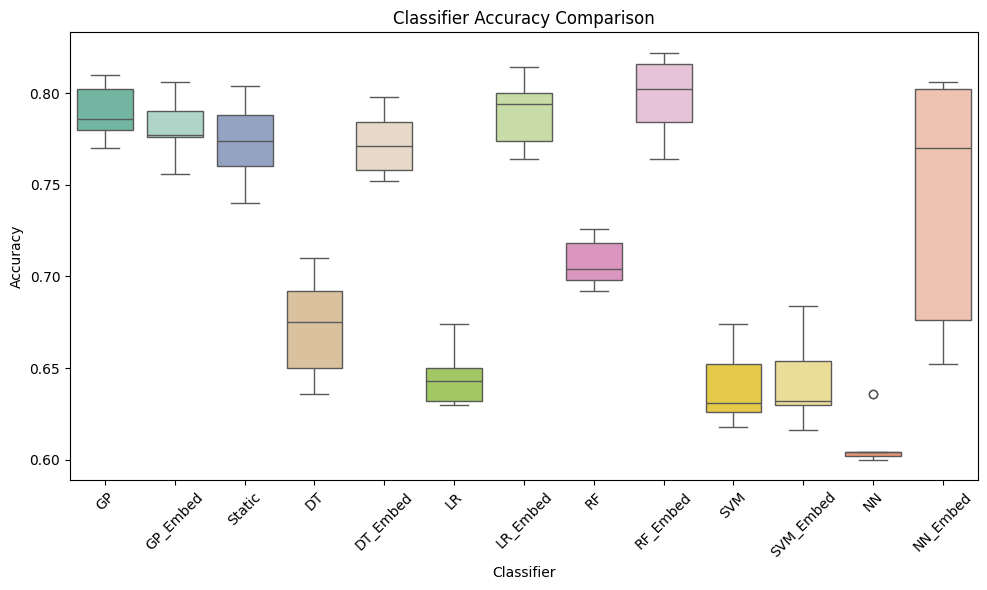

In [18]:
# Prepare data for plotting
flat_data = []
flat_labels = []
for clf, scores in accuracy_scores.items():
    flat_data.extend(scores)
    flat_labels.extend([clf] * len(scores))

acc_df = pd.DataFrame({"Accuracy": flat_data, "Classifier": flat_labels})

# Define a custom color palette
base_classifiers = set([c.split("_")[0] for c in accuracy_scores.keys()])
base_colors = sns.color_palette("Set2", n_colors=len(base_classifiers))  # Ensure enough colors for unique classifiers

custom_palette = {}
for idx, clf in enumerate(base_classifiers):
    if clf == "Static":
        base_color = base_colors[idx]
        custom_palette[f"{clf}"] = base_color
    else:
        base_color = base_colors[idx]
        custom_palette[f"{clf}"] = base_color
        custom_palette[f"{clf}_Embed"] = sns.light_palette(base_color, n_colors=3)[1]  # Lighter shade

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="Classifier",
    y="Accuracy",
    data=acc_df,
    palette=custom_palette,
)
plt.title("Classifier Accuracy Comparison")
plt.xlabel("Classifier")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


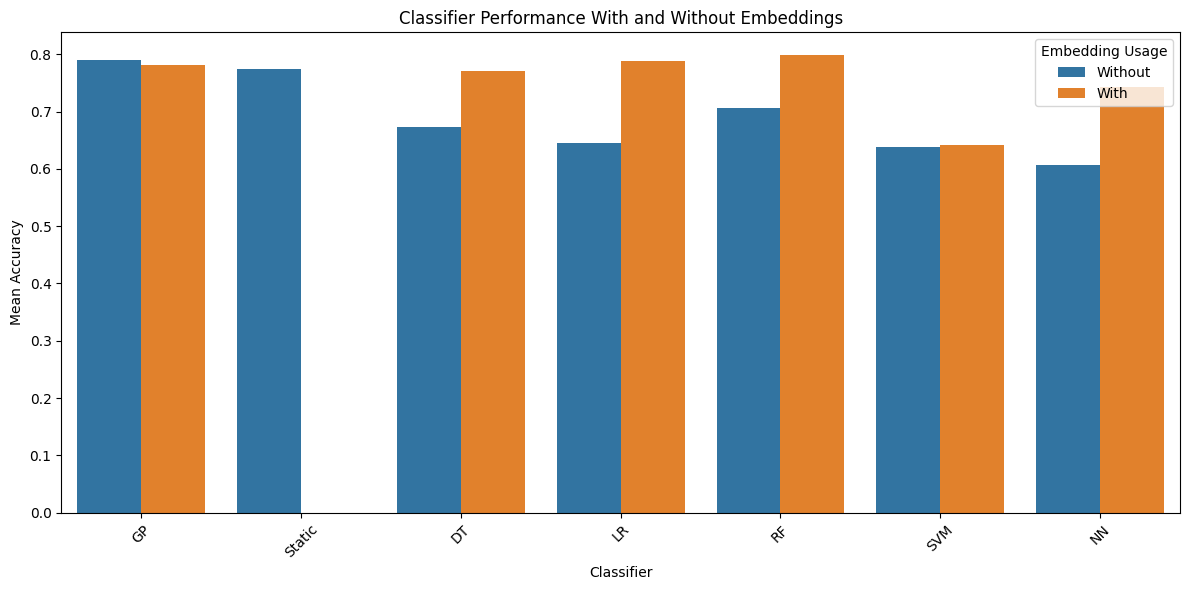

In [19]:
metrics_df = pd.DataFrame([
    {"Classifier": clf.split("_")[0], "Embedding": "With" if "Embed" in clf else "Without", 
     "Accuracy": np.mean([score["accuracy"] for score in scores])}
    for clf, scores in metrics_storage.items()
])

plt.figure(figsize=(12, 6))
sns.barplot(x="Classifier", y="Accuracy", hue="Embedding", data=metrics_df)
plt.title("Classifier Performance With and Without Embeddings")
plt.ylabel("Mean Accuracy")
plt.xlabel("Classifier")
plt.xticks(rotation=45)
plt.legend(title="Embedding Usage")
plt.tight_layout()
plt.show()


In [20]:
# Step 1: Kruskal-Wallis Test (Global Comparison)
model_names = list(accuracy_scores.keys())
gp_models = ["GP", "GP_Embed"]
all_models = gp_models + [name for name in model_names if name not in gp_models]
scores_list = [accuracy_scores[name] for name in all_models]
kw_stat, kw_p_value = kruskal(*scores_list)

print("=== Kruskal-Wallis Test ===")
print(f"Statistic: {kw_stat:.4f}, P-value: {kw_p_value:.4e}\n")

# Display summary of Kruskal-Wallis results
if kw_p_value < 0.05:
    print("Significant differences detected (p < 0.05).")
else:
    print("No significant differences detected (p >= 0.05).")

# Step 2: Wilcoxon Signed-Rank Tests (Pairwise Comparisons)
# Compare GP and GP_Embed against other models
other_models = [name for name in model_names if name not in gp_models]

wilcoxon_results = []
for gp_model in gp_models:
    for other_model in other_models:
        # Perform the Wilcoxon test
        stat, p = wilcoxon(
            accuracy_scores[gp_model],
            accuracy_scores[other_model],
            alternative="two-sided",
            zero_method="zsplit"  # Handles zero differences safely
        )
        wilcoxon_results.append({
            "GP Model": gp_model,
            "Other Model": other_model,
            "Statistic": stat,
            "P-value": p
        })

# Adjust p-values for Wilcoxon tests using Bonferroni correction
wilcoxon_p_values = [result["P-value"] for result in wilcoxon_results]
reject, corrected_p_values, _, _ = multipletests(wilcoxon_p_values, alpha=0.05, method="bonferroni")

# Add corrected p-values and significance flags to Wilcoxon results
for i, result in enumerate(wilcoxon_results):
    result["Corrected P-value"] = corrected_p_values[i]
    result["Significant"] = "Yes" if reject[i] else "No"

# Step 3: Post Hoc Bonferroni Analysis
# Perform Mann-Whitney U for GP models vs. all others
post_hoc_results = []
for gp_model in gp_models:
    for other_model in other_models:
        # Mann-Whitney U test
        stat, p = mannwhitneyu(
            accuracy_scores[gp_model],
            accuracy_scores[other_model],
            alternative="two-sided"
        )
        post_hoc_results.append({
            "GP Model": gp_model,
            "Other Model": other_model,
            "Statistic": stat,
            "P-value": p
        })

# Bonferroni correction for post hoc comparisons
post_hoc_p_values = [result["P-value"] for result in post_hoc_results]
reject, corrected_p_values, _, _ = multipletests(post_hoc_p_values, alpha=0.05, method="bonferroni")

# Add corrected p-values and significance flags to post hoc results
for i, result in enumerate(post_hoc_results):
    result["Corrected P-value"] = corrected_p_values[i]
    result["Significant"] = "Yes" if reject[i] else "No"

# Step 4: Organize Results into DataFrames
# Wilcoxon results
wilcoxon_df = pd.DataFrame(wilcoxon_results)
print("\n=== Wilcoxon Signed-Rank Test Results ===")
print(wilcoxon_df)

# Post hoc results
post_hoc_df = pd.DataFrame(post_hoc_results)
print("\n=== Post Hoc Pairwise Comparisons (Bonferroni) ===")
print(post_hoc_df)

# Step 5: Summary Statistics
summary_results = {
    "Model": all_models,
    "Mean Accuracy": [np.mean(accuracy_scores[model]) for model in all_models],
    "Std Dev Accuracy": [np.std(accuracy_scores[model], ddof=1) for model in all_models]
}
summary_df = pd.DataFrame(summary_results)
print("\n=== Summary Statistics ===")
print(summary_df)

# Save results to CSV files
wilcoxon_df.to_csv(f"wilcoxon_results_{num_rows}.csv", index=False)
post_hoc_df.to_csv(f"post_hoc_results_{num_rows}.csv", index=False)
summary_df.to_csv(f"summary_statistics{num_rows}.csv", index=False)


=== Kruskal-Wallis Test ===
Statistic: 213.0102, P-value: 6.6644e-39

Significant differences detected (p < 0.05).

=== Wilcoxon Signed-Rank Test Results ===
    GP Model Other Model  Statistic   P-value  Corrected P-value Significant
0         GP      Static        0.0  0.000002           0.000042         Yes
1         GP          DT        0.0  0.000002           0.000042         Yes
2         GP    DT_Embed       15.0  0.000261           0.005749         Yes
3         GP          LR        0.0  0.000002           0.000042         Yes
4         GP    LR_Embed       81.0  0.388376           1.000000          No
5         GP          RF        0.0  0.000002           0.000042         Yes
6         GP    RF_Embed       46.0  0.026642           0.586121          No
7         GP         SVM        0.0  0.000002           0.000042         Yes
8         GP   SVM_Embed        0.0  0.000002           0.000042         Yes
9         GP          NN        0.0  0.000002           0.000042        